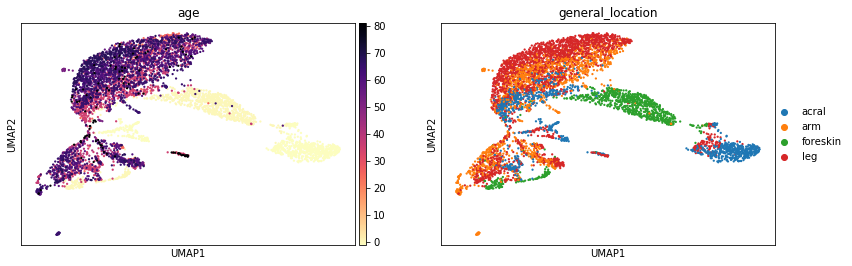

... storing 'noise_group' as categorical


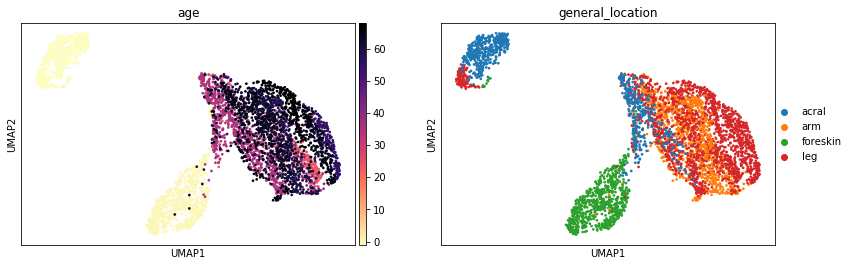

Completed


In [78]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import display, HTML

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


4283
2801
2684


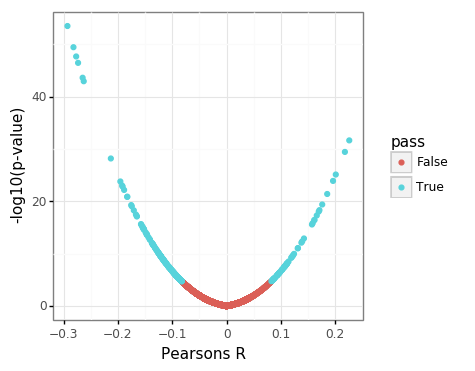

<ggplot: (-9223363249574915559)>


,gene,R,pval,R2,neglog10_pval
7426,PTGDS,-0.292924,2.968066e-54,0.085805,53.527526
3255,GPR155,-0.281860,3.360261e-50,0.079445,49.473627
630,ATP1B1,-0.276876,1.964885e-48,0.076660,47.706663
2951,FRG2DP,-0.273360,3.292525e-47,0.074726,46.482471
3729,IFI27,-0.264996,2.281688e-44,0.070223,43.641744
8121,SERPINF1,-0.262974,1.071735e-43,0.069155,42.969913
7558,RAMP1,0.225855,2.179292e-32,0.051011,31.661685
6246,NDRG2,0.217805,3.481127e-30,0.047439,29.458280
677,B2M,-0.213077,6.241459e-29,0.045402,28.204714
4660,LMNA,0.201002,7.288216e-26,0.040402,25.137379


querying 1-20...done.
Finished.
1 input query terms found dup hits:
	[('FRG2DP', 2)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
0: PTGDS
The protein encoded by this gene is a glutathione-independent prostaglandin D synthase that catalyzes the conversion of prostaglandin H2 (PGH2) to postaglandin D2 (PGD2). PGD2 functions as a neuromodulator as well as a trophic factor in the central nervous system. PGD2 is also involved in smooth muscle contraction/relaxation and is a potent inhibitor of platelet aggregation. This gene is preferentially expressed in brain. Studies with transgenic mice overexpressing this gene suggest that this gene may be also involved in the regulation of non-rapid eye movement sleep. [provided by RefSeq, Jul 2008].
1: GPR155
N/A
2: ATP1B1
The protein encoded by this gene belongs to the family of Na+/K+ and H+/K+ ATPases beta chain proteins, and to the subfamily of Na+/K+ -ATPases. Na+/K+ -ATPase is an integral membrane protein

CSRP2 is a member of the CSRP family of genes, encoding a group of LIM domain proteins, which may be involved in regulatory processes important for development and cellular differentiation. CRP2 contains two copies of the cysteine-rich amino acid sequence motif (LIM) with putative zinc-binding activity, and may be involved in regulating ordered cell growth. Other genes in the family include CSRP1 and CSRP3. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Jul 2014].
19: MT2A
This gene is a member of the metallothionein family of genes. Proteins encoded by this gene family are low in molecular weight, are cysteine-rich, lack aromatic residues, and bind divalent heavy metal ions, altering the intracellular concentration of heavy metals in the cell. These proteins act as anti-oxidants, protect against hydroxyl free radicals, are important in homeostatic control of metal in the cell, and play a role in detoxification of heavy metals. The encoded protein in

In [79]:
###############################################
###############################################
# Correlation between expression and true age
# Returns correlation statistics and gene function annotation
###############################################
###############################################

# Specify number of genes to print from top of list sorted on R2
topn = 20

# Specify whether to use all samples or only adult samples in correlation
adults_only = True

# Specify whether to remove acral general_location
exclude_acral = True

# Specify whether to remove foreskin general_location
exclude_foreskin = True

###############################################

ref = 'age'
input_adata = adata_subset2
print(len(input_adata))
exclusion_list = []
if exclude_foreskin == True:
    exclusion_list = exclusion_list + ['foreskin']
if exclude_acral == True:
    exclusion_list = exclusion_list + ['acral']
input_adata = input_adata[[x not in exclusion_list for x in input_adata.obs.general_location]]
print(len(input_adata))

if adults_only == True:
    input_adata = input_adata[input_adata.obs.age > 0]
print(len(input_adata))

corr_age = pd.DataFrame(input_adata.X)
corr_age.columns = input_adata.var_names
corr_age[ref] = input_adata.obs[ref].tolist()

df = corr_age.dropna()._get_numeric_data()
r_list = []
p_list = []
gene_list = []
for col in df.columns.tolist():
    r, pval = pearsonr(df[ref], df[col])
    r_list.append(r)
    p_list.append(pval)
    gene_list.append(col)
out_df = pd.DataFrame({'gene':gene_list,
                       'R':r_list, 
                       'pval':p_list})
out_df = out_df.iloc[[x != ref for x in out_df['gene']],:]
out_df['R2'] = out_df['R']**2 
out_df = out_df.sort_values('R2', ascending=False)
out_df['pval'] = out_df['pval'].replace(0, min([x for x in out_df['pval'] if x>0]))
out_df['neglog10_pval'] = -np.log10(out_df['pval'])
out_df['pass'] = out_df.neglog10_pval > -np.log10(0.05/len(df))

# plot R vs p-value
plotnine.options.figure_size=(4,4)
print(ggplot(out_df)
          +theme_bw()
          +geom_point(aes('R','neglog10_pval', color = 'pass'))
          +labs(x='Pearsons R', y='-log10(p-value)'))

# print correlation scores table
display(out_df.drop('pass', axis = 1).head(topn))

# search correlation df
gene = out_df.gene[:topn]
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
output = [print(x) for x in full_report if search_term in x]

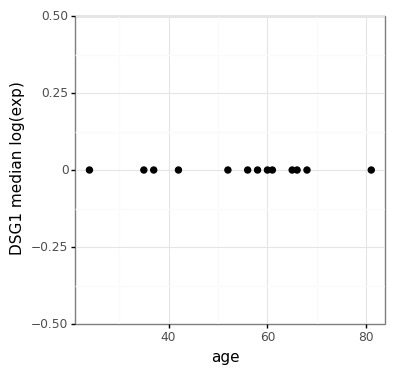

<ggplot: (8787283256517)>


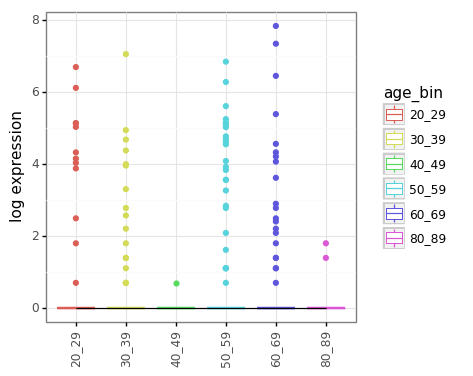

<ggplot: (8787283334706)>


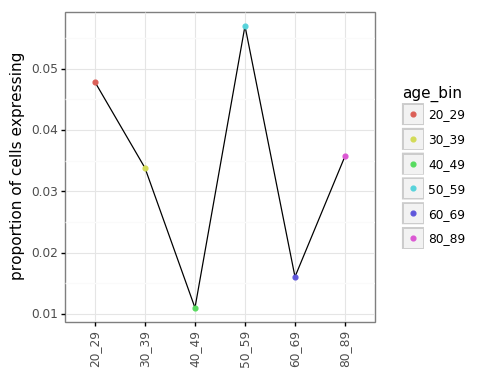

<ggplot: (-9223363249577021636)>


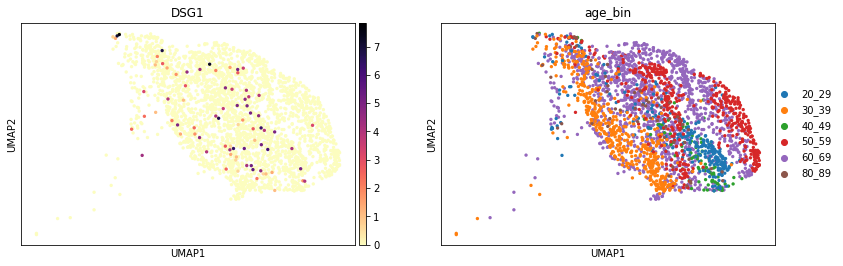

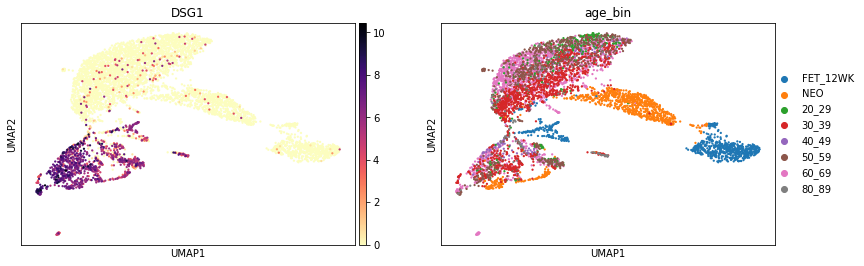

querying 1-1...done.
Finished.
0:  DSG1 
 This gene encodes a member of the desmoglein protein subfamily. Desmogleins, along with desmocollins, are cadherin-like transmembrane glycoproteins that are major components of the desmosome. Desmosomes are cell-cell junctions that help resist shearing forces and are found in high concentrations in cells subject to mechanical stress. This gene is found in a cluster with other desmoglein family members on chromosome 18. The encoded protein has been identified as a target of auto-antibodies in the autoimmune skin blistering disease pemphigus foliaceus. Disruption of this gene has also been associated with the skin diseases palmoplantar keratoderma and erythroderma. [provided by RefSeq, Feb 2015].


In [90]:
###############################################
###############################################
# Single-gene expression statistics
# Returns single-gene expression statistics as a function of true age
###############################################
###############################################

# Specify gene symbol
gene = 'DSG1'

# Specify age-binning: 'age_group' = 30-yr bins, 'age_bin' = 10-yr bins
groupby='age_bin'

###############################################

# true age
true_age_exp(gene, input_adata)

# binned age
gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, groupby], cmap='magma_r')
sc.pl.umap(full_adata, color=[gene, groupby], cmap='magma_r')

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# DEV

4283
2801
2684


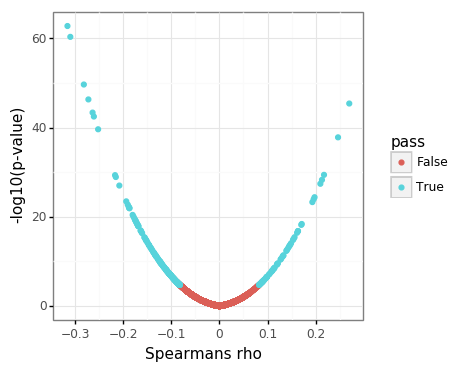

<ggplot: (-9223363298410619511)>


,gene,rho,pval,neglog10_pval
3255,GPR155,-0.316438,1.734206e-63,62.760899
630,ATP1B1,-0.310460,4.652391e-61,60.332324
7426,PTGDS,-0.282345,2.252123e-50,49.647408
3729,IFI27,-0.272846,4.956838e-47,46.304795
4660,LMNA,0.270176,4.084600e-46,45.388850
2951,FRG2DP,-0.264137,4.407805e-44,43.355778
677,B2M,-0.261457,3.387160e-43,42.470164
9449,TPPP3,-0.252595,2.430771e-40,39.614256
6246,NDRG2,0.246804,1.555845e-38,37.808034
3343,GSN,0.217593,3.966775e-30,29.401562


querying 1-20...done.
Finished.
1 input query terms found dup hits:
	[('FRG2DP', 2)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
0: GPR155
N/A
1: ATP1B1
The protein encoded by this gene belongs to the family of Na+/K+ and H+/K+ ATPases beta chain proteins, and to the subfamily of Na+/K+ -ATPases. Na+/K+ -ATPase is an integral membrane protein responsible for establishing and maintaining the electrochemical gradients of Na and K ions across the plasma membrane. These gradients are essential for osmoregulation, for sodium-coupled transport of a variety of organic and inorganic molecules, and for electrical excitability of nerve and muscle. This enzyme is composed of two subunits, a large catalytic subunit (alpha) and a smaller glycoprotein subunit (beta). The beta subunit regulates, through assembly of alpha/beta heterodimers, the number of sodium pumps transported to the plasma membrane. The glycoprotein subunit of Na+/K+ -ATPase is encoded by mul

In [4]:
# Spearman's rho #

###############################################
###############################################
# Correlation between expression and true age
# Returns correlation statistics and gene function annotation
###############################################
###############################################

# Specify number of genes to print from top of list sorted on R2
topn = 20

# Specify whether to use all samples or only adult samples in correlation
adults_only = True

# Specify whether to remove acral general_location
exclude_acral = True

# Specify whether to remove foreskin general_location
exclude_foreskin = True

###############################################

ref = 'age'
input_adata = adata_subset2
print(len(input_adata))
exclusion_list = []
if exclude_foreskin == True:
    exclusion_list = exclusion_list + ['foreskin']
if exclude_acral == True:
    exclusion_list = exclusion_list + ['acral']
input_adata = input_adata[[x not in exclusion_list for x in input_adata.obs.general_location]]
print(len(input_adata))

if adults_only == True:
    input_adata = input_adata[input_adata.obs.age > 0]
print(len(input_adata))

corr_age = pd.DataFrame(input_adata.X)
corr_age.columns = input_adata.var_names
corr_age[ref] = input_adata.obs[ref].tolist()

df = corr_age.dropna()._get_numeric_data()
r_list = []
p_list = []
gene_list = []
for col in df.columns.tolist():
    r, pval = stats.spearmanr(df[ref], df[col])
    r_list.append(r)
    p_list.append(pval)
    gene_list.append(col)
out_df = pd.DataFrame({'gene':gene_list,
                       'rho':r_list, 
                       'pval':p_list})
out_df = out_df.iloc[[x != ref for x in out_df['gene']],:]
out_df = out_df.sort_values('pval', ascending=True)
out_df['pval'] = out_df['pval'].replace(0, min([x for x in out_df['pval'] if x>0]))
out_df['neglog10_pval'] = -np.log10(out_df['pval'])
out_df['pass'] = out_df.neglog10_pval > -np.log10(0.05/len(df))

# plot R vs p-value
plotnine.options.figure_size=(4,4)
print(ggplot(out_df)
          +theme_bw()
          +geom_point(aes('rho','neglog10_pval', color = 'pass'))
          +labs(x='Spearmans rho', y='-log10(p-value)'))

# print correlation scores table
display(out_df.drop('pass', axis = 1).head(topn))

# search correlation df
gene = out_df.gene[:topn]
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
output = [print(x) for x in full_report if search_term in x]